# YOLOFakeImagesDetection - Notebook

This notebook is a preparatory step for the application, where:
1. We prepare the dataset for the segmentation task.
2. We train our model using the created dataset.
3. We save the steps to use it as a pre-trained model in the application.

The model is focused on solving a problem of detecting bounding boxes and subsequently segmenting the masks of the fake regions in the image, if any.

We should have already downloaded the dataset, which should look like this:

```bash
downloaded_dataset/
│── images/              # CASIA v2 images
│   │── real/            # Original images
│   │── forged/          # Manipulated images
│── masks/               # Masks of fake regions (ground truth)
│   │── forged/          # Masks corresponding to manipulated images
```
For each manipulated image named `name.jpg`, its mask `name_gt.png` should be converted into segmentation coordinates. The way we will build our dataset is as follows:

1. Load the images and their masks.

2. Extract the contours of the fake region (manipulated area) using `extract_contours`.

3. Convert the contours to YOLO format (normalized coordinates) and save them.

YOLO format for segmentation:
```
<class_id> x1 y1 x2 y2 x3 y3 x4 y4 ... xn yn
```

Each mask has a single object of class "0" (manipulation).

We will format our downloaded dataset:

In [ ]:
import os
import glob
import random
import shutil
import cv2
import numpy as np
from tqdm import tqdm

def clean_dirs(base_path):
    """Deletes files in the 'train', 'val', and 'test' directories before processing."""
    for split in ['train', 'val', 'test']:
        split_image_dir = os.path.join(base_path, 'images', split)
        split_label_dir = os.path.join(base_path, 'labels', split)
        
        # Delete the images
        for file in os.listdir(split_image_dir):
            file_path = os.path.join(split_image_dir, file)
            if os.path.isfile(file_path):
                os.remove(file_path)
        
        # Delete the labels
        for file in os.listdir(split_label_dir):
            file_path = os.path.join(split_label_dir, file)
            if os.path.isfile(file_path):
                os.remove(file_path)

def create_dirs(base_path):
    """Creates the directory structure for YOLO."""
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(base_path, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(base_path, 'labels', split), exist_ok=True)

def split_dataset(images, masks, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    """Splits the dataset into train, val, and test sets according to the given ratios."""
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "The percentages must sum to 1.0"
    
    combined = list(zip(images, masks))
    random.shuffle(combined)
    
    train_end = int(len(combined) * train_ratio)
    val_end = train_end + int(len(combined) * val_ratio)
    
    return combined[:train_end], combined[train_end:val_end], combined[val_end:]

def extract_contours(mask_path):
    """Extracts contours from the binary mask and converts them into normalized YOLO coordinates."""
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    h, w = mask.shape
    
    yolo_data = []
    for contour in contours:
        if len(contour) < 3:  # Must be at least a triangle
            continue
        
        contour = contour.squeeze()
        if len(contour.shape) == 1:
            continue
        
        # Normalize the contour coordinates for YOLO
        normalized_contour = [str(coord / w) if i % 2 == 0 else str(coord / h) for i, coord in enumerate(contour.flatten())]
        yolo_data.append(f"0 {' '.join(normalized_contour)}")
    
    return yolo_data

def process_dataset(base_input, base_output, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    """Prepares the dataset in YOLO format."""
    
    # Clean directories before processing
    clean_dirs(base_output)
    
    create_dirs(base_output)
    
    # Filter images with common formats
    image_formats = ['.jpg', '.jpeg', '.png', '.tif', '.tiff']
    forged_images = []
    for fmt in image_formats:
        forged_images.extend(glob.glob(os.path.join(base_input, f'images/forged/*{fmt}')))
    
    # Filter masks (assuming masks are also .png or .jpg)
    masks = []
    for fmt in image_formats:
        masks.extend(glob.glob(os.path.join(base_input, f'masks/forged/*{fmt}')))
        
    # Ensure there is a mask for each image
    forged_images.sort()
    masks.sort()
    
    # Split the dataset into train, val, test
    train, val, test = split_dataset(forged_images, masks, train_ratio, val_ratio, test_ratio)
    
    for split_name, dataset in zip(['train', 'val', 'test'], [train, val, test]):
        for img_path, mask_path in tqdm(dataset, desc=f'Processing {split_name}'):
            filename = os.path.basename(img_path)
            
            # Copy images to the corresponding directory
            shutil.copy(img_path, os.path.join(base_output, 'images', split_name, filename))
            
            # Extract contours and convert to YOLO format
            yolo_labels = extract_contours(mask_path)
            
            if yolo_labels:
                label_filename = filename.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt').replace('.tif', '.txt').replace('.tiff', '.txt')
                with open(os.path.join(base_output, 'labels', split_name, label_filename), 'w') as f:
                    f.write('\n'.join(yolo_labels))

# Configuration
base_input = './datasets/downloaded_dataset' # Path where CASIA v2 dataset (to be formatted) is stored
base_output = './datasets/custom_dataset'    # New folder with YOLO format => Where the dataset will be saved and used for training

# Run dataset processing
process_dataset(base_input, base_output)

Processing test:   3%|▎         | 16/513 [00:00<00:03, 127.61it/s]


KeyboardInterrupt: 

We create a `data.yaml` file for YOLO, e.g.:
```yaml
train: ./datasets/custom_dataset/images/train
val: ./datasets/custom_dataset/images/valid
test: ./datasets/custom_dataset/images/test

nc: 1
names: ["manipulated"]
```
Ultralytics assumes that the labels are in a directory parallel to the images.

In [ ]:
# The first step is to load the model configuration from the `config.yaml`:

import yaml

def load_config(config_path):
    """Loads the configuration from a YAML file."""
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    return config

# Load the configuration
config_path = './config.yaml'  # Path to the YAML file
config = load_config(config_path)

# Configuración extraída del YAML
task = config['task']
mode = config['mode']
model = config['model']
data = config['data']
epochs = config['epochs']
imgsz = config['imgsz']
batch_size = config['batch_size']
project = config['project']
name = config['name']

KeyError: 'epochs'

We run the **training** from the CLI (the model will be saved in `./models/my_model` if `project: ./models`, `name: my_model` is specified in `config.yaml`):

In [ ]:
# Delete the folder where the model will be saved, to avoid creating new folders by appending a number as a suffix.
output_dir_path = os.path.join(project, name)
if os.path.exists(output_dir_path):
    shutil.rmtree(output_dir_path)
    print(f"Deleted the existing folder: {output_dir_path}")

# Dynamically build the CLI command
command = f"yolo task={task} mode={mode} model={model} data={data} epochs={epochs} imgsz={imgsz} batch={batch_size} project={project} name={name}"

# Execute the command directly in the notebook with '!'
!{command}

Deleted the existing folder: ./output/test


15464.20s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Ultralytics 8.3.75 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7832MiB)
YOLOv8n-seg summary (fused): 195 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs
val: Scanning /opt/YOLOFakeImagesDetection/datasets/custom_dataset/labels/test../opt/YOLOFakeImagesDetection/.yolofid/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
val: Scanning /opt/YOLOFakeImagesDetection/datasets/custom_dataset/labels/test..
val: New cache created: /opt/YOLOFakeImagesDetection/datasets/custom_dataset/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  m
Traceback (most recent call last):
  File "/opt/YOLOFakeImagesDetection/.yolofid/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/opt/YOLOFakeImagesDetection/.yolofid/lib/python3.10/site-packages/ultralytics/cfg/__init__.py", line 986, in entrypoint
    getattr(model, mode)(**overrides)  # defau

If we look closely, after training and validation, the best model found is usually saved as `best.pt` at the end. The base YOLO models you chose are also downloaded in `.pt `format and stored in the root folder; you can delete them.

Once our model is trained, we can use it; uncomment the test configuration in `config.yaml` and test it with our train subset from the CLI:

In [ ]:
# The first step is to load the model configuration from the `config.yaml`:

import yaml

def load_config(config_path):
    """Loads the configuration from a YAML file."""
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    return config

# Load the configuration
config_path = './config.yaml'  # Path to the YAML file
config = load_config(config_path)

# Configuration extracted from the YAML file
task = config['task']
mode = config['mode']
model = config['model']
data = config['data']
imgsz = config['imgsz']
source = config['source']
save = config['save']
project = config['project']
name = config['name']

We run the **test** from CLI (the results will be saved in `./output/test` if `project: ./output`, `name: test` are specified in `config.yaml`):

(It’s worth mentioning that although we are doing **testing**, we are in `mode=val` in `config.yaml` and `val: /opt/YOLOFakeImagesDetection/datasets/custom_dataset/images/test` in `data.yaml`, so that metrics like mAP, precision, recall, etc., are automatically calculated using the labels from `labels/test`. If we set `mode=test`, it would only run inference and save the images, but no result metrics would be calculated since it wouldn’t evaluate against ground truth). After this, you need to switch back to `mode=predict` and `val: /opt/YOLOFakeImagesDetection/datasets/custom_dataset/images/val`, otherwise, the model will use the wrong validation data in the next training.

In [ ]:
# Delete the folder where the results will be saved, first, to prevent it from creating new folders by appending a number as a suffix:
output_dir_path = os.path.join(project, name)
if os.path.exists(output_dir_path):
    shutil.rmtree(output_dir_path)
    print(f"Deleted the existing folder: {output_dir_path}")

# Dynamically build the CLI command
command_test = f"yolo task={task} mode={mode} model={model} data={data} imgsz={imgsz} source={source} save={save} project={project} name={name}"

# Execute the command directly in the notebook with '!'
!{command_test}

Deleted the existing folder: ./output/test


16700.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Ultralytics 8.3.75 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7832MiB)
YOLOv8n-seg summary (fused): 195 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs
val: Scanning /opt/YOLOFakeImagesDetection/datasets/custom_dataset/labels/val.ca
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all       1024       1253      0.776      0.598      0.662      0.547      0.783       0.59      0.658      0.502
Speed: 0.3ms preprocess, 2.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to output/test
💡 Learn more at https://docs.ultralytics.com/modes/val


Finally, before we start programming our web application, **let's test** the model **with a single image**:

In [ ]:
# The first step is to load the model configuration from the `config.yaml`:

import yaml

def load_config(config_path):
    """Loads the configuration from a YAML file."""
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    return config

# Load the configuration
config_path = './config.yaml'  # Path to the YAML file
config = load_config(config_path)

# Extracted configuration from the YAML
task = config['task']
mode = config['mode']
model = config['model']
data = config['data']
imgsz = config['imgsz']
source = config['source']
save = config['save']
project = config['project']
name = config['name']

In [ ]:
source_image = "/opt/YOLOFakeImagesDetection/assets/Tp_D_CND_M_N_ani00018_sec00096_00138.png" # Change to the manipulated image path
output_directory_name = "single_test" # No need to change

In [ ]:
# Delete the folder where the result will be saved, to avoid creating new folders with a suffix
output_dir_path = os.path.join(project, output_directory_name)
if os.path.exists(output_dir_path):
    shutil.rmtree(output_dir_path)
    print(f"Deleted the existing folder: {output_dir_path}")
    
# Dynamically construct the CLI command
command_test = f"yolo mode={mode} model={model} imgsz={imgsz} source={source_image} save={save} project={project} name={output_directory_name}"

# Execute the command directly in the notebook with '!'
!{command_test}

Deleted the existing folder: ./output/single_test


16847.60s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Ultralytics 8.3.75 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7832MiB)
YOLOv8n-seg summary (fused): 195 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs

image 1/1 /opt/YOLOFakeImagesDetection/assets/Tp_D_CND_M_N_ani00018_sec00096_00138.png: 448x640 1 manipulated, 31.1ms
Speed: 1.0ms preprocess, 31.1ms inference, 81.4ms postprocess per image at shape (1, 3, 448, 640)
Results saved to output/single_test
💡 Learn more at https://docs.ultralytics.com/modes/predict


The result of the **prediction** with the input test image:

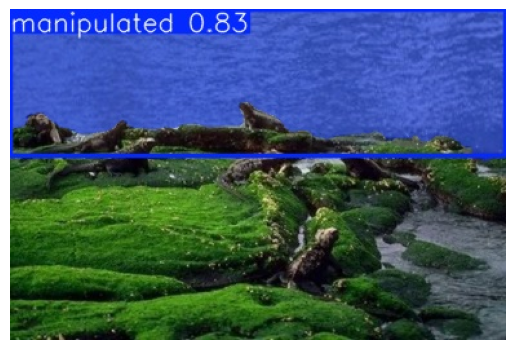

In [113]:
import os
import cv2
import matplotlib.pyplot as plt
output_dir = './output/single_test/'
output_files = os.listdir(output_dir)
if output_files:
    output_image_path = os.path.join(output_dir, output_files[0])
    img = cv2.imread(output_image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off') 
    plt.show()
else:
    print(f"No images found in {output_dir}.")